<a href="https://colab.research.google.com/github/ChidinmaKO/Nyasa-CV/blob/master/Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on workshop: Image classification with Keras 

In this notebook you will learn how to build a convolutional neural network from scratch with Keras. You will build a simple network to classify one of the most well-known datasets in the world of image classification - the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/). You can generalize the steps we follow in this tutorial to virtually any image dataset. Of course, with more complex images with more subtle differences between them, you will need to train much deeper and wider networks, for much longer periods of time. Luckily with transfer learning, you can use a pre-trained network trained on a *different* dataset, andfine-tune it to your particular dataset. We will see an example of this in the second part of the notebook.

PS: Check out the Maths behind [Gradient Descent](https://www.google.com/search?ei=F52UXOCcB4zQwQLi5IX4Cw&q=math+of+gradient+descent&oq=math+of+gradient&gs_l=psy-ab.1.0.0i22i30l10.54584.56354..57582...0.0..0.59.514.10......0....1..gws-wiz.......0i71j35i39j0i10j0j0i13j0i13i30j0i22i10i30.Fi7EMvFzaDw) and [Backpropagation](https://www.google.com/search?q=math+of+backpropagation&oq=math+of+back&aqs=chrome.0.0j69i57j0l4.6514j0j1&sourceid=chrome&ie=UTF-8)

## Part 1: Getting the data

We will be working with the deep learning library Keras. Keras comes with a bunch of datasets that you can play around with, including MNIST. Let's start by importing the libraries we need for this project.

In [0]:
import numpy as np
np.random.seed(123) # For reproducibility

from matplotlib import pyplot as plt

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras import optimizers

from keras.utils import np_utils

from keras.datasets import mnist

Using TensorFlow backend.


It is worth spending a bit of time here to look at the [documentation](https://keras.io/datasets/#mnist-database-of-handwritten-digits) of the Keras MNIST dataset. The load_data function gives you pre-shuffled MNIST data in train and test sets.

In [0]:
# Load pre-shuffled MNIST data into train and test sets
##########################################################
#
# ToDo: Use mnist.load_data() and unpack this data into two tuples for training and test data respectively
#
#
#########################################################
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# Take a look at the shape of the data arrays
print("X_train (data) shape", X_train.shape)
print("y_train (labels) shape", y_train.shape)
print("X_test (data) shape", X_test.shape)
print("y_test (labels) shape", y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
X_train (data) shape (60000, 28, 28)
y_train (labels) shape (60000,)
X_test (data) shape (10000, 28, 28)
y_test (labels) shape (10000,)


Let's take a look at some of the images in our dataset. We're going to use the matplotlib library and the function pyplot to plot our images.

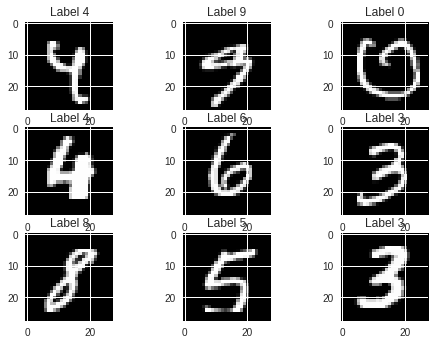

In [0]:
for i in range(9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[index], cmap='gray', interpolation='none')
    plt.title("Label {}".format(y_train[index]))



## Part 2: Formatting the data so that we can feed it to the network

* When you are using Keras with TensorFlow as a backend, the input to a convolutional neural network is of the format (n_images, n_rows, n_cols, n_channels), where n_images is the numbner of images in your training set or batch, n_rows and n_cols are the number of rows and columns of pixels, and n_channels is the number of color channels (1 for black and white, 3 for colored images). As we have already seen that the format of the data is currently (n_images, n_rows, n_cols), we need to add an extra dimension for n_channels.  
* It is always useful to normalize your input data, so that rather than ranging from 0 to 255, the pixel values in your image range from 0 to 1 instead. This makes it easier to train your network.
* Finally, since our labels are categorical, and we need them to be numeric for our network to be able to calculate a loss, we one-hot-encode our labels. That is, convert each label into a vector as follows:  
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]  
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]  
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]  
etc.

In [0]:
# Reshape input data
#
# ToDo: reshape X data with .reshape, to shape[0], 28, 28, 1
#
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Convert input data type to float
#
# ToDo: use the astype(float32) to convert data type
#
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize input data
#
# ToDo: divide by 255
#
X_train /= 255
X_test /= 255

# Convert 1-dimensional class arrays to 10-dimensional class matrices
#
# ToDo: convert y data to categorical with 10 categories using np_utils.to_categorical
#
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

## Part 3: Building our neural network with Keras

There are two ways of building a neural network with Keras. The [Sequential](https://keras.io/getting-started/sequential-model-guide/) method and the [Functional](https://keras.io/getting-started/functional-api-guide/) method. The Functional method is useful for building very complex networks with fancy connections, but we will look at the simpler Sequential method for now.  

In [0]:
# Some parameters for the network
batch_size = 128 # Change this to experiment - best to keep it a power of 2
epochs = 12      # Change this to experiment - train as many epochs as you see the loss decreasing, but no more

num_classes = 10 # This depends on your data. In MNIST, 10 digits from 0 to 9.

First we declare a sequential model. Then we add some layers. This is the part where you experiment. Add different kinds of layers, with different amounts of filters. Experiment with dropout and normalization layers. Experiment with adding more layers. The [Keras documentation](https://keras.io/) is your friend, but for convenience I have added some useful info about commonly used layers right here:  
* [Convolutional layers](https://keras.io/layers/convolutional/) - This is your standard convolution. You specify the number of filters and the kernel size, and if you need to you can change the stride and the padding.
* [Max Pooling layers](https://keras.io/layers/pooling/#maxpooling2d) - These layers take a high resolution image and make it slightly lower resolution. A max pooling layer usually follows a convolutional layer.
* [Batch Normalization](https://keras.io/layers/normalization/) - A very useful layer. It normalizes the input from the previous layer, to have close to 0 mean and unit standard deviation. This helps a lot in training networks faster, with the slight disadvantage of having more parameters to train.
* [Dropout](https://keras.io/layers/core/#dropout) - This layer randomly turns off a percentage of the neurons entering it from the previous layer, at each epoch during training time. The net effect of this is to share weights more evenly across neurons, which results in less overfitting and makes the netowrk more likely to generalize to test data.
* [Dense layers](https://keras.io/layers/core/#dense) - Your standard run-of-the-mill fully connected layer. After a bunch of convolutions and max-pooling to extract features, you will add a few dense layers to do the classification.  
I have built a sample neural network below to show you how it's done, but feel free to experiment with it.

In [0]:
# First we declare a sequential model
model = Sequential()

# Add layers
# 1 - Convolutional and pooling layers for learning features
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))

#
# TODO: Add some convolutional, maxpooling, batchnorm, dropout, etc layers here
#
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=1-0.25))
model.add(Flatten())

# Note that after each convolution and max pool the output height and width changes.

# 2 - Fully connected layers for classifying the features

#
# ToDO: Add fully connected layers and dropout layers here
#

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=1-0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

## Part 4: Compile the model

We configure the model for training with the model.compile command. We have to specify a loss, an optimizer, and the metrics we are measuring. As far as the loss goes, just remember that for a multi-label classification you would use binary cross-entropy whereas for a multi-class classification where each example belongs to a single class, you would use categorical cross entropy. The optimizer could be plain old gradient descent, but there are so many faster and more efficient [optimizers](https://keras.io/optimizers/) out there now which you should definitely play around with.

In [0]:
# ToDo: Pick an optimizer and specify its parameters such as learning rate
model_optimizer = optimizers.Adadelta(lr=1.0)

model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

## Part 5: Train the model

This is the part where the weights of the model are adjusted via gradient descent (or a variation of gradient descent specified by the optimizer). With backprop, all the weights in the hidden layers are updated via the chain rule, and at each epoch your model's predictions become a bit better.

In [0]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 13s 224us/step - loss: 0.3324 - acc: 0.8957 - val_loss: 0.0871 - val_acc: 0.9740
Epoch 2/12
60000/60000 [==============================] - 9s 143us/step - loss: 0.1306 - acc: 0.9607 - val_loss: 0.0575 - val_acc: 0.9828
Epoch 3/12
60000/60000 [==============================] - 9s 143us/step - loss: 0.1067 - acc: 0.9672 - val_loss: 0.0452 - val_acc: 0.9855
Epoch 4/12
60000/60000 [==============================] - 9s 143us/step - loss: 0.0915 - acc: 0.9728 - val_loss: 0.0369 - val_acc: 0.9868
Epoch 5/12
60000/60000 [==============================] - 9s 143us/step - loss: 0.0856 - acc: 0.9739 - val_loss: 0.0364 - val_acc: 0.9881
Epoch 6/12
60000/60000 [==============================] - 8s 141us/step - loss: 0.0769 - acc: 0.9768 - val_loss: 0.0351 - val_acc: 0.9883
Epoch 7/12
60000/60000 [==============================] - 9s 142us/step -

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Test accuracy - 98.99%

Test loss: 0.02863833036584547
Test accuracy: 0.9899


## Intermezzo: Visualizing the outputs of the hidden layers

A lot of people like to say that neural networks are a black box. That it is difficult to figure on what exactly a neural network is calculating. This makes them hesitant to use neural networks, and they go for more well-understood machine learning algorithms like support vector machines or decision trees. This is not a true statement, especially in the case of convolutional networks. One can easily see the outputs of each hidden layer for a particular input, because the hidden layer outputs are images themselves. You can refer to the excellent paper [Zeiler & Fergus(2013) - Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) to see examples of hidden layer outputs. We will write a small function to do just that with our classifier.

<img src="https://github.com/VikramRadhakrishnan/DeepCV/blob/master/nb_images/CNN_feature_extract.png?raw=1">

In [0]:
from keras.models import Model

def visualize_a_layer(image, n_layer, model_network):
    '''Visualize the filters of layer n of a conv net.
    image: the input image to the network
    n_layer: the number of the layer to visualize
    model_network: the neural network'''
    
    vis_model = Model([model_network.layers[0].input], [model_network.layers[n_layer].output])
    vis_model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])
    activations = vis_model.predict(image)[0]
    
    # The index 2 corresponds to the filter number so we traverse all filters
    box = int(np.sqrt(activations.shape[2]))
    for filt in range(activations.shape[2]):
        plt.subplot(box,box,filt+1)
        plt.imshow(activations[:,:,filt], cmap='gray', interpolation='none')

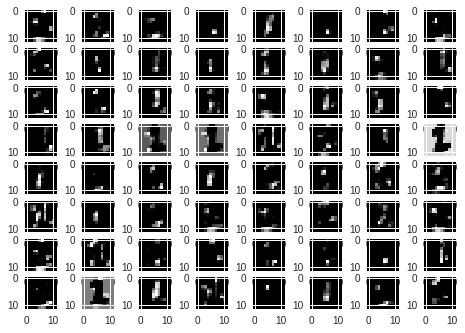

In [0]:
img_to_visualize = np.expand_dims(X_train[70], axis=0)
visualize_a_layer(img_to_visualize, 2, model)

## Part 6: Transfer learning with Keras

A very nifty feature of convolutional neural netowrks is that the earlier layers learn very basic shapes, edges, and low-level features that are common to all objects. So a powerful neural network that has been trained on many images could be re-used for a totally different problem with a completely different dataset. We just fine-tune the last few layers of the network and we have a state-of-the-art classifier, while barely doing any work ourselves. The rest of this notebook will show you how to use the trained deep neural networks that are built into Keras - neural networks that have achieved record breaking accuracies at image classification problems.

### Getting the dataset
We will use a set of [25,000 images of dogs and cats from Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data). Our goal is to train a classifier to differentiate between dogs and cats.

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
# Download the data
import os
if not os.path.exists("train.zip"):
    !kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 26.8MB/s]
 99% 268M/271M [00:02<00:00, 138MB/s]
100% 271M/271M [00:02<00:00, 135MB/s]
 99% 540M/543M [00:14<00:00, 32.9MB/s]
100% 543M/543M [00:14<00:00, 38.1MB/s]


In [0]:
# Unzip the files
import zipfile
zip_train = zipfile.ZipFile("train.zip", 'r')
zip_train.extractall()
zip_train.close()

zip_test = zipfile.ZipFile("test1.zip", 'r')
zip_test.extractall()
zip_test.close()

In [0]:
# Visualize the data
import random
from keras.preprocessing import image

filenames = os.listdir("train/")

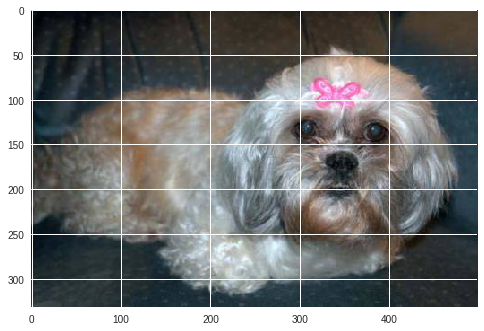

In [0]:
sample = random.choice(filenames)
rand_image = image.load_img("train/"+sample)
plt.imshow(rand_image)

### Image data augmentation
If you inspect the data you will see that every image has a different width and height. We need a way to make them all the same shape to feed into the convnet. Also, we have plenty of images here, but it's always nicer to have more variety in our data. One way of doing this would be to randomly translate or rotate the images or mirror them. We can address both of these themes with data augmentation. Keras provides an image data augmentation class which we can use to get a larger dataset of same sized images from the training data.  
To make things easier, let's first split the data into a training folder and a validation folder. Then, let's move all the dogs into a folder named dogs and cats into a folder named cats. An image is a dog if it has the word "dog" in its name and cat if it contains "cat" in its name.

In [0]:
import glob
import shutil
from random import sample

# Create a directory for validation data
if not os.path.exists("validate"):
    os.mkdir("validate")

# Move 20% of training data to validation
files = os.listdir("train/")
vfiles = sample(files, int(0.2 * len(files)))
for f in vfiles:
    shutil.move("train/" + f, "validate/" + f)

# Create separate folders for dogs and cats
if not os.path.exists("train/dogs"):
    os.mkdir("train/dogs")
if not os.path.exists("train/cats"):
    os.mkdir("train/cats")

for image in glob.glob("train/cat.*"):
    shutil.move(image, "train/cats/.")
for image in glob.glob("train/dog.*"):
    shutil.move(image, "train/dogs/.")

if not os.path.exists("validate/dogs"):
    os.mkdir("validate/dogs")
if not os.path.exists("validate/cats"):
    os.mkdir("validate/cats")

for image in glob.glob("validate/cat.*"):
    shutil.move(image, "validate/cats/.")
for image in glob.glob("validate/dog.*"):
    shutil.move(image, "validate/dogs/.")

Now we set up the Image Data Generator.

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

# The augmentation configuration we will use for training
# ToDo: Make an image data generator here with relevant transformations
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2, 
                                         zoom_range=0.2, 
                                         horizontal_flip=True
                                        )

# The augmentation configuration we will use for testing:
# ToDo: Make an image data generator here with relevant transformations for the test data
test_datagen = image.ImageDataGenerator(rescale=1./255)

# This generator will generate augmented data from the training folder
train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=16,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# This is a similar generator, for validation data
# ToDo: Do the same for the validation data but point it to the validate directory
validation_generator = test_datagen.flow_from_directory('validate', 
                                                        target_size=(150, 150),
                                                        batch_size=16,
                                                        class_mode='binary'
                                                       )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Now we import the pre-trained VGG16 model from Keras.

In [0]:
from keras import applications


VGGmodel = applications.VGG16(weights='imagenet', include_top=False, input_shape = (150,150,3))

VGGmodel.summary()

# ToDo: Homework - check out the other pretrained networks available in Keras such as Resnet and Inception

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

We add on a few extra layers at the end to fine-tune it for our dataset.

In [0]:
# Build a classifier model to put on top of the convolutional model
# Here we need to use the functional method of building a neural network in Keras

top_model = Flatten()(VGGmodel.output)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

full_model = Model([VGGmodel.input], [top_model])
# Set the first 16 layers to non-trainable (weights will not be updated)
for layer in full_model.layers[:16]:
    layer.trainable = False

In [0]:
full_model.compile(loss='binary_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

In [0]:
full_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Epoch 1/50
15/15 [==============================] - 5s 319ms/step - loss: 2.0133 - acc: 0.5333 - val_loss: 0.6814 - val_acc: 0.5833
Epoch 2/50
15/15 [==============================] - 2s 166ms/step - loss: 0.6954 - acc: 0.5292 - val_loss: 0.6957 - val_acc: 0.4479
Epoch 3/50
15/15 [==============================] - 3s 197ms/step - loss: 0.6925 - acc: 0.4792 - val_loss: 0.6699 - val_acc: 0.5521
Epoch 4/50
15/15 [==============================] - 3s 198ms/step - loss: 0.7317 - acc: 0.5792 - val_loss: 0.6477 - val_acc: 0.6354
Epoch 5/50
15/15 [==============================] - 3s 198ms/step - loss: 0.6344 - acc: 0.6667 - val_loss: 0.7797 - val_acc: 0.5938
Epoch 6/50
15/15 [==============================] - 3s 197ms/step - loss: 0.7115 - acc: 0.6958 - val_loss: 0.3465 - val_acc: 0.8542
Epoch 7/50
15/15 [==============================] - 3s 200ms/step - loss: 0.4789 - acc: 0.7875 - val_loss: 1.1263 - val_acc: 0.6250
Epoch 8/50
15/15 [==============================] - 3s 197ms/step - loss: 0.

Note that the state of the art in dogs vs cats classification was an accuracy of around 59% back in 2012. How far we have come!